In [72]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from sklearn.feature_selection import SelectKBest, f_classif

In [26]:
df = pd.read_csv("/workspaces/Final_Project_DataScient/data/processed/datafinal.csv")
df

,HHADULT,SEXVAR,MEDCOST1,SLEPTIM1,CVDSTRK3,ADDEPEV3,DIABETE4,MARITAL,RENTHOM1,VETERAN3,...,_ASTHMS1,_DRDXAR2,_AGEG5YR,_BMI5CAT,_CHLDCNT,_EDUCAG,_INCOMG1,_RFBING6,_AIDTST4,tobacco_use
0,2,1.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,0.0,8.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0
1,4,1.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,8.0,2.0,0.0,3.0,-1.0,0.0,0.0,0.0
2,2,1.0,0.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.0,1.0,6.0,3.0,0.0,1.0,2.0,0.0,0.0,0.0
3,2,0.0,0.0,6.0,0.0,0.0,3.0,0.0,0.0,0.0,...,3.0,0.0,6.0,3.0,0.0,2.0,5.0,0.0,0.0,0.0
4,2,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,0.0,8.0,3.0,0.0,2.0,3.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109974,1,0.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3.0,1.0,8.0,2.0,0.0,2.0,5.0,1.0,0.0,1.0
109975,4,0.0,0.0,7.0,1.0,0.0,3.0,0.0,1.0,0.0,...,3.0,1.0,9.0,2.0,0.0,3.0,5.0,0.0,1.0,0.0
109976,2,1.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,0.0,6.0,2.0,1.0,3.0,4.0,0.0,1.0,0.0
109977,1,1.0,1.0,5.0,0.0,0.0,0.0,0.0,2.0,0.0,...,3.0,0.0,9.0,0.0,0.0,1.0,-1.0,-1.0,0.0,2.0


In [27]:
df["ADDEPEV3"].value_counts(normalize=True)

ADDEPEV3
0.0    0.793233
1.0    0.206767
Name: proportion, dtype: float64

# 🏁 Modelado Predictivo

## 🎯 Introducción
Este notebook tiene como objetivo construir y evaluar un modelo de aprendizaje automático para **predecir la variable objetivo** a partir de un conjunto de datos inicial. El dataset utilizado presenta desafíos típicos en ciencia de datos, como:

- **Clases desbalanceadas**, lo que exige evaluar diferentes estrategias de balanceo.
- Gran cantidad de **características**, para las que es clave evaluar métodos de selección y reducción de variables.

A lo largo del notebook se realizan pruebas para:

- Comparar diferentes modelos base (Logistic Regression, Random Forest, XGBoost, entre otros).
- Evaluar distintos enfoques para imputación de nulos (`NaN → -1` vs eliminación de registros).
- Aplicar diferentes estrategias de balance de clases (undersampling, oversampling, class weighting).
- Analizar el impacto de diversos métodos de selección de características (`SelectKBest`, importancia de características en Random Forest/XGBoost).
- Identificar y justificar el modelo final seleccionado para la tarea.

## 🔍 Resultado Esperado
Al finalizar, contar con:

✅ Una comparación clara de rendimientos para cada estrategia implementada.  
✅ El modelo final seleccionado junto a su justificación.  


In [28]:
def show_metrics(y_test, y_pred_test, y_train, y_pred_train):    
    accuracy_test = accuracy_score(y_test, y_pred_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    f1_score_test = f1_score(y_test, y_pred_test)
    f1_score_train = f1_score(y_train, y_pred_train)
    precision_test = precision_score(y_test, y_pred_test)
    precision_train = precision_score(y_train, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)
    recall_train = recall_score(y_train, y_pred_train)

    print("\nRESULTADOS DEL MODELO")
    print("=" * 50)
    print(f"{'Métrica':<15} {'Test':<10} {'Train':<10}")
    print("-" * 50)
    print(f"{'Accuracy':<15} {accuracy_test:<10.2f} {accuracy_train:<10.2f}")
    print(f"{'F1 Score':<15} {f1_score_test:<10.2f} {f1_score_train:<10.2f}")
    print(f"{'Precision':<15} {precision_test:<10.2f} {precision_train:<10.2f}")
    print(f"{'Recall':<15} {recall_test:<10.2f} {recall_train:<10.2f}")
    print("=" * 50)

In [29]:
# DIVISION DE DATOS EN TRAIN Y TEST
X = df.drop("ADDEPEV3", axis = 1)
y = df["ADDEPEV3"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 42)

In [30]:
# ESCALADO DE VARIABLES PARA MODELOS LINEALES O BASADOS EN DISTANCIAS
scaler = StandardScaler().fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

## ⚡️ Fase 1: Pruebas Iniciales con el Dataset Original

### 🎯 Descripción
En esta primera fase, trabajamos con la **data tal cual está**:
- Sin eliminar variables.
- Conservando los valores "faltantes" representados como `-1`.
- Sin aplicar ninguna técnica de imputación o balanceo de clases.

### 🔍 Objetivo
Obtener una línea base para evaluar:
- El rendimiento inicial de diferentes modelos.
- La importancia de procesar o no los datos antes de continuar.

### 🛠️ Modelos Evaluados
- Logistic Regression
- Random Forest
- XGBoost
- Otros modelos base relevantes.

### 📊 Resultados
*(Se incluirán métricas alcanzadas por cada modelo para establecer una línea base.)*


In [31]:
# REGRESION LOGISTICA
log_reg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

y_pred_test = log_reg.predict(X_test_scaled)
y_pred_train = log_reg.predict(X_train_scaled)

show_metrics(y_test, y_pred_test, y_train, y_pred_train)


RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.77       0.78      
F1 Score        0.56       0.57      
Precision       0.47       0.47      
Recall          0.69       0.70      


In [32]:
# KNN
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

y_pred_test = knn.predict(X_test_scaled)
y_pred_train = knn.predict(X_train_scaled)

show_metrics(y_test, y_pred_test, y_train, y_pred_train)


RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.81       0.86      
F1 Score        0.42       0.58      
Precision       0.58       0.78      
Recall          0.32       0.46      


In [33]:
# RANDOM FOREST
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

y_pred_test = rf.predict(X_test)
y_pred_train = rf.predict(X_train)

show_metrics(y_test, y_pred_test, y_train, y_pred_train)


RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.83       1.00      
F1 Score        0.47       1.00      
Precision       0.69       1.00      
Recall          0.36       1.00      


In [34]:
# XGBoost
xgb = XGBClassifier(random_state=42, scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]))
xgb.fit(X_train, y_train)

y_pred_test = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)

show_metrics(y_test, y_pred_test, y_train, y_pred_train)


RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.77       0.81      
F1 Score        0.56       0.63      
Precision       0.46       0.53      
Recall          0.70       0.79      


In [35]:
# MLPClassifier
mlp = MLPClassifier(random_state=42, max_iter=1000)
mlp.fit(X_train_scaled, y_train)

y_pred_test = mlp.predict(X_test_scaled)
y_pred_train = mlp.predict(X_train_scaled)

show_metrics(y_test, y_pred_test, y_train, y_pred_train)



RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.83       0.86      
F1 Score        0.49       0.59      
Precision       0.63       0.77      
Recall          0.40       0.48      


In [36]:
cat_model = CatBoostClassifier(random_state=42, class_weights={0:1, 1:len(y_train[y_train==0])/len(y_train[y_train==1])},
                               verbose=0)

cat_model.fit(X_train, y_train)

y_pred_test = cat_model.predict(X_test)
y_pred_train = cat_model.predict(X_train)

show_metrics(y_test, y_pred_test, y_train, y_pred_train)


RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.77       0.81      
F1 Score        0.56       0.63      
Precision       0.47       0.52      
Recall          0.71       0.79      


## ⚡️ Fase 2: Codificación de Variables Categóricas y Modelos Finalistas

### 🎯 Descripción
Tras evaluar varios modelos en la Fase 1, vamos a continuar con la segunda fase:
- Aplicar **codificación one‑hot** (`pd.get_dummies`) a aquellas variables categóricas relevantes.
- Utilizar esta versión transformada del dataset para evaluar nuevamente los modelos que obtuvieron **mejor rendimiento** en la fase inicial.

### 🛠️ Pasos a Seguir
1. Identificación de variables categóricas clave para codificación.
2. Aplicación de `pd.get_dummies` para representar dichas variables de manera adecuada para el modelo.
3. Entrenar nuevamente los modelos finalistas sobre la versión codificada del dataset.
4. Comparar resultados para evaluar la ganancia en métricas clave (`accuracy`, `recall`, `f1`, etc.).

### ✅ Resultado Esperado
Obtener una versión del dataset con mayor capacidad explicativa para los modelos finalistas, mejorando su rendimiento y solidez.

In [37]:
X_train_dummies = pd.get_dummies(X_train, columns=["_BMI5CAT", "MARITAL", "RENTHOM1", "EMPLOY1"])
X_test_dummies = pd.get_dummies(X_test, columns=["_BMI5CAT", "MARITAL", "RENTHOM1", "EMPLOY1"])

scaler = StandardScaler().fit(X_train_dummies)

X_train_dummies_scaled = pd.DataFrame(scaler.transform(X_train_dummies), index=X_train_dummies.index, columns=X_train_dummies.columns)
X_test_dummies_scaled = pd.DataFrame(scaler.transform(X_test_dummies), index=X_test_dummies.index, columns=X_test_dummies.columns)

In [ ]:
# REGRESION LOGISTICA
log_reg.fit(X_train_dummies_scaled, y_train)

y_pred_test = log_reg.predict(X_test_dummies_scaled)
y_pred_train = log_reg.predict(X_train_dummies_scaled)

show_metrics(y_test, y_pred_test, y_train, y_pred_train)


RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.77       0.78      
F1 Score        0.56       0.57      
Precision       0.47       0.47      
Recall          0.69       0.71      


In [ ]:
# XGBoost
xgb.fit(X_train_dummies, y_train)

y_pred_test = xgb.predict(X_test_dummies)
y_pred_train = xgb.predict(X_train_dummies)

show_metrics(y_test, y_pred_test, y_train, y_pred_train)


RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.77       0.81      
F1 Score        0.56       0.63      
Precision       0.46       0.53      
Recall          0.70       0.79      


In [ ]:
cat_model.fit(X_train_dummies, y_train)

y_pred_test = cat_model.predict(X_test_dummies)
y_pred_train = cat_model.predict(X_train_dummies)

show_metrics(y_test, y_pred_test, y_train, y_pred_train)


RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.77       0.81      
F1 Score        0.56       0.63      
Precision       0.47       0.52      
Recall          0.71       0.79      


## 🗑️ Fase 3: Eliminación de Registros con Valores `-1` (Sin Respuesta)

### 🎯 Descripción
Tras evaluar la codificación de variables categóricas mediante `pd.get_dummies` y obtener métricas similares al dataset original, procederemos a:
- **Eliminar registros con `-1`**, que corresponden a preguntas sin respuesta en la encuesta.
- Limpiar el dataset para evaluar si esta eliminación contribuye a una mejora en la calidad del modelo.

### 🛠️ Pasos a Seguir
1. Identificación de todas las variables que contienen `-1` como indicador de ausencia de datos.
2. Filtrado de registros para excluir aquellas filas que presenten `-1`.
3. Entrenar nuevamente los modelos finalistas para evaluar cambios en:
    - **Accuracy**
    - **Recall**
    - **Precision**

### ✅ Resultado Esperado
Obtener un dataset más coherente para evaluar si la eliminación de registros con datos ausentes aporta una mejora en la capacidad predictiva de los modelos seleccionados.


In [41]:
mask = (df != -1).all(axis=1)
df_clean = df[mask]

X = df_clean.drop("ADDEPEV3", axis=1)
y = df_clean["ADDEPEV3"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [42]:
# ESCALADO DE VARIABLES PARA MODELOS LINEALES O BASADOS EN DISTANCIAS
scaler = StandardScaler().fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [ ]:
# REGRESION LOGISTICA
log_reg.fit(X_train_scaled, y_train)

y_pred_test = log_reg.predict(X_test_scaled)
y_pred_train = log_reg.predict(X_train_scaled)

show_metrics(y_test, y_pred_test, y_train, y_pred_train)


RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.77       0.78      
F1 Score        0.56       0.57      
Precision       0.47       0.47      
Recall          0.71       0.71      


In [ ]:
# XGBoost
xgb.fit(X_train, y_train)

y_pred_test = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)

show_metrics(y_test, y_pred_test, y_train, y_pred_train)


RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.77       0.82      
F1 Score        0.56       0.65      
Precision       0.46       0.54      
Recall          0.70       0.80      


In [ ]:
cat_model.fit(X_train, y_train)

y_pred_test = cat_model.predict(X_test)
y_pred_train = cat_model.predict(X_train)

show_metrics(y_test, y_pred_test, y_train, y_pred_train)


RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.77       0.81      
F1 Score        0.56       0.63      
Precision       0.47       0.53      
Recall          0.71       0.79      


## ⚖️ Fase 4: Balanceo de Clases con SMOTE y SMOTEENN

### 🎯 Descripción
Tras evaluar los modelos ganadores en las fases previas, vamos a continuar con la **fase de balanceo de clases** para mejorar la representación de la clase minoritaria en el dataset.  
Se aplicarán dos enfoques:

- **SMOTE**: Genera ejemplos sintéticos para aumentar la clase minoritaria.  
- **SMOTEENN**: Combina la generación de datos sintéticos con la limpieza de muestras ruidosas para obtener un balance más robusto.

### 🛠️ Pasos a Seguir
1. Aplicar **SMOTE** para obtener un conjunto de entrenamiento balanceado.
2. Aplicar **SMOTEENN** para obtener un conjunto de entrenamiento balanceado y depurado.
3. Entrenar nuevamente los modelos ganadores en cada versión del dataset balanceado.
4. Evaluar y comparar las métricas para determinar qué técnica aporta la mayor mejora.

### ✅ Resultado Esperado
Obtener conclusiones claras sobre la efectividad de cada técnica de balanceo para mejorar el rendimiento en la clase minoritaria.


In [ ]:
# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Aplicar SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)

# Resultado
print(f"Original: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"SMOTE: X_train={X_train_smote.shape}, y_train={y_train_smote.shape}")
print(f"SMOTEENN: X_train={X_train_smoteenn.shape}, y_train={y_train_smoteenn.shape}")


Original: X_train=(61898, 38), y_train=(61898,)
SMOTE: X_train=(98304, 38), y_train=(98304,)
SMOTEENN: X_train=(71422, 38), y_train=(71422,)


In [48]:
# ESCALADO DE VARIABLES PARA MODELOS LINEALES O BASADOS EN DISTANCIAS
scaler = StandardScaler().fit(X_train_smote)

X_train_smote_scaled = pd.DataFrame(scaler.transform(X_train_smote), index=X_train_smote.index, columns=X_train_smote.columns)
X_test_smote_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

scaler = StandardScaler().fit(X_train_smoteenn)

X_train_smoteen_scaled = pd.DataFrame(scaler.transform(X_train_smoteenn), index=X_train_smoteenn.index, columns=X_train_smoteenn.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [49]:
# REGRESION LOGISTICA
log_reg.fit(X_train_smote_scaled, y_train_smote)

y_pred_test = log_reg.predict(X_test_scaled)
y_pred_train = log_reg.predict(X_train_smote_scaled)

show_metrics(y_test, y_pred_test, y_train_smote, y_pred_train)


RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.79       0.76      
F1 Score        0.57       0.75      
Precision       0.49       0.78      
Recall          0.67       0.72      


In [53]:
# REGRESION LOGISTICA
log_reg.fit(X_train_smoteen_scaled, y_train_smoteenn)

y_pred_test = log_reg.predict(X_test_scaled)
y_pred_train = log_reg.predict(X_train_smoteen_scaled)

show_metrics(y_test, y_pred_test, y_train_smoteenn, y_pred_train)


RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.73       0.84      
F1 Score        0.54       0.86      
Precision       0.41       0.92      
Recall          0.78       0.81      


In [55]:
# XGBoost
xgb.fit(X_train_smote, y_train_smote)

y_pred_test = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train_smote)

show_metrics(y_test, y_pred_test, y_train_smote, y_pred_train)


RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.77       0.88      
F1 Score        0.56       0.89      
Precision       0.46       0.83      
Recall          0.71       0.95      


In [56]:
# XGBoost
xgb.fit(X_train_smoteenn, y_train_smoteenn)

y_pred_test = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train_smoteenn)

show_metrics(y_test, y_pred_test, y_train_smoteenn, y_pred_train)


RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.69       0.94      
F1 Score        0.52       0.95      
Precision       0.38       0.93      
Recall          0.82       0.98      


In [51]:
cat_model.fit(X_train_smote, y_train_smote)

y_pred_test = cat_model.predict(X_test)
y_pred_train = cat_model.predict(X_train_smote)

show_metrics(y_test, y_pred_test, y_train_smote, y_pred_train)


RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.77       0.88      
F1 Score        0.56       0.89      
Precision       0.46       0.83      
Recall          0.72       0.95      


In [57]:
cat_model.fit(X_train_smoteenn, y_train_smoteenn)

y_pred_test = cat_model.predict(X_test)
y_pred_train = cat_model.predict(X_train_smoteenn)

show_metrics(y_test, y_pred_test, y_train_smoteenn, y_pred_train)


RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.69       0.94      
F1 Score        0.52       0.96      
Precision       0.38       0.93      
Recall          0.82       0.98      


### ⚖️ Conclusión sobre el Balanceo de Clases
La ligera mejora en el rendimiento de algunos modelos al aplicar **SMOTE** y **SMOTEENN** no justifica su implementación en este contexto.  
Dada la naturaleza del problema —de ámbito médico—, es preferible:

- Mantener la integridad de los datos reales.  
- Abordar el desbalance de clases mediante otros enfoques (cost-sensitive learning, ajuste de pesos de clase, métricas específicas) en lugar de sintetizar registros.

Por tanto, **no se aplicará balanceo de clases** en la versión final del modelo.  
Se procederá a evaluar otras estrategias, como la **sobre-selección de parámetros** para afinar los modelos ganadores.


## 🎯 Fase 5: Selección de Features

### 🕵️ Descripción
Una vez finalizada la evaluación de modelos y estrategias de balanceo, abordamos la **selección de características** para:
- Identificar las variables más relevantes para la predicción.
- Mejorar la interpretabilidad del modelo.
- Reducir la dimensionalidad para disminuir el riesgo de sobreajuste.

Se aplicarán diferentes métodos de selección de atributos:
- **SelectKBest**: Basado en pruebas estadísticas para evaluar la relevancia de cada variable.
- **Importancia de Features**: Utilizando modelos basados en árboles (Random Forest, XGBoost) para obtener la importancia de cada variable.

### ✅ Resultado Esperado
Obtener un conjunto de atributos más relevante para:
- Mejorar el rendimiento de los modelos ganadores.
- Aumentar la interpretabilidad de los resultados en un contexto médico.


In [ ]:
# Selección de Features con SelectKBest
k = 15
selector = SelectKBest(score_func=f_classif, k=k)

# Ajuste del selector
X_train_kbest = selector.fit_transform(X_train, y_train)

# Identificación de las columnas seleccionadas
mask = selector.get_support()
selected_columns = X_train.columns[mask]
print(f"✅ Features seleccionadas ({k}):\n", selected_columns)

X_test_kbest = X_test.loc[:, selected_columns]

print(f"X_train_kbest shape: {X_train_kbest.shape}")
print(f"X_test_kbest shape: {X_test_kbest.shape}")

✅ Features seleccionadas (15):
 Index(['SEXVAR', 'DECIDE', 'DIFFALON', 'LSATISFY', 'EMTSUPRT', 'SDHISOLT',
       'SDHFOOD1', 'SDHBILLS', 'SDHTRNSP', '_PHYS14D', '_MENT14D', '_ASTHMS1',
       '_DRDXAR2', '_INCOMG1', '_AIDTST4'],
      dtype='object')
X_train_kbest shape: (61898, 15)
X_test_kbest shape: (15475, 15)


In [63]:
# XGBoost
xgb.fit(X_train_kbest, y_train)

y_pred_test = xgb.predict(X_test_kbest)
y_pred_train = xgb.predict(X_train_kbest)

show_metrics(y_test, y_pred_test, y_train, y_pred_train)


RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.76       0.78      
F1 Score        0.55       0.59      
Precision       0.45       0.48      
Recall          0.71       0.76      


In [64]:
cat_model.fit(X_train_kbest, y_train)

y_pred_test = cat_model.predict(X_test_kbest)
y_pred_train = cat_model.predict(X_train_kbest)

show_metrics(y_test, y_pred_test, y_train, y_pred_train)


RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.76       0.78      
F1 Score        0.55       0.59      
Precision       0.44       0.48      
Recall          0.72       0.76      


## 🔥 Fase 5.1: Importancia de Features con XGBoost y CatBoost

### 🎯 Descripción
Se evaluarán las características más relevantes para la predicción utilizando la importancia interna de:
- **XGBoost**
- **CatBoost**

Esta estrategia permite:
- Identificar las variables que más contribuyen al rendimiento del modelo.
- Mejorar la interpretabilidad en un contexto médico.

### ⚡️ Pasos
1. Entrenar los modelos finales (XGBoost y CatBoost) sobre el conjunto de datos completo.
2. Obtener e interpretar la importancia de cada feature (`feature_importances_`).
3. Utilizar esta información para valorar qué variables aportan al modelo y considerar futuras reducciones de dimensionalidad.

### ✅ Resultado Esperado
Una visión clara de qué variables son clave para predecir la variable objetivo, fortaleciendo tanto la interpretabilidad como la eficiencia del modelo final.



Top 15 Features en XGBoost:
      Feature  Importance
24  _MENT14D    0.387729
10    DECIDE    0.139240
1     SEXVAR    0.047702
17  SDHISOLT    0.038226
29  _DRDXAR2    0.034488
36  _AIDTST4    0.021250
15  LSATISFY    0.018860
23  _PHYS14D    0.015903
28  _ASTHMS1    0.014525
31  _BMI5CAT    0.012363
33   _EDUCAG    0.011694
13  HIVRISK5    0.011692
11  DIFFALON    0.011577
9    EMPLOY1    0.011386
26  _TOTINDA    0.011247


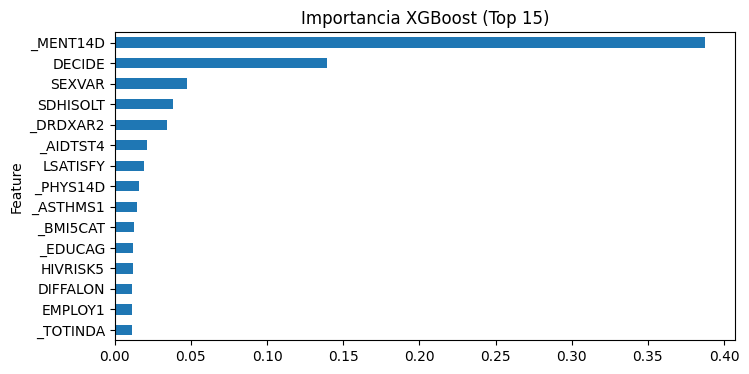


Top 15 Features en CatBoost:
      Feature  Importance
24  _MENT14D   14.134969
30  _AGEG5YR    6.156757
3   SLEPTIM1    5.778743
10    DECIDE    4.694302
34  _INCOMG1    4.609420
1     SEXVAR    4.555144
6    MARITAL    4.497361
33   _EDUCAG    4.052494
9    EMPLOY1    3.832195
15  LSATISFY    3.629018
31  _BMI5CAT    3.400000
0    HHADULT    3.210824
23  _PHYS14D    3.076822
17  SDHISOLT    3.060456
29  _DRDXAR2    2.791113


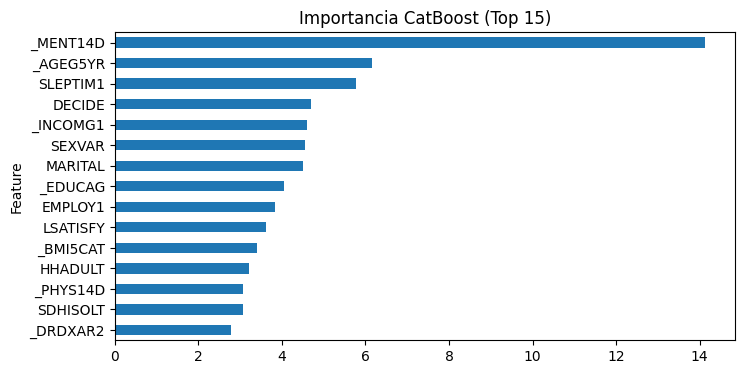

In [66]:
xgb.fit(X_train, y_train)

importance_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 15 Features en XGBoost:\n", importance_xgb.head(15))

importance_xgb.head(15).plot(kind='barh', x='Feature', y='Importance', figsize=(8,4), title="Importancia XGBoost (Top 15)", legend=False)
plt.gca().invert_yaxis()
plt.show()


cat_model.fit(X_train, y_train)

importance_cat = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': cat_model.get_feature_importance()
}).sort_values(by='Importance', ascending=False)

print("\nTop 15 Features en CatBoost:\n", importance_cat.head(15))

importance_cat.head(15).plot(kind='barh', x='Feature', y='Importance', figsize=(8,4), title="Importancia CatBoost (Top 15)", legend=False)
plt.gca().invert_yaxis()
plt.show()


In [67]:
# Aplicación de Modelos con Features Más Importantes
N = 15

# Selección de Features para XGBoost
top_xgb_features = importance_xgb.head(N)['Feature'].values
X_train_xgb_best = X_train[top_xgb_features]
X_test_xgb_best = X_test[top_xgb_features]

# Entrenar y evaluar XGBoost
xgb.fit(X_train_xgb_best, y_train)
y_pred_test_xgb = xgb.predict(X_test_xgb_best)
y_pred_train_xgb = xgb.predict(X_train_xgb_best)

show_metrics(y_test, y_pred_test_xgb, y_train, y_pred_train_xgb)

# Selección de Features para CatBoost
top_cat_features = importance_cat.head(N)['Feature'].values
X_train_cat_best = X_train[top_cat_features]
X_test_cat_best = X_test[top_cat_features]

# Entrenar y evaluar CatBoost
cat_model.fit(X_train_cat_best, y_train)
y_pred_test_cat = cat_model.predict(X_test_cat_best)
y_pred_train_cat = cat_model.predict(X_train_cat_best)

show_metrics(y_test, y_pred_test_cat, y_train, y_pred_train_cat)


RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.76       0.79      
F1 Score        0.55       0.60      
Precision       0.45       0.49      
Recall          0.70       0.77      

RESULTADOS DEL MODELO
Métrica         Test       Train     
--------------------------------------------------
Accuracy        0.76       0.80      
F1 Score        0.56       0.61      
Precision       0.45       0.50      
Recall          0.72       0.78      


## 🏁 Conclusión Final de la Etapa de Modelado

Tras evaluar diferentes modelos (Logistic Regression, KNN, Random Forest, XGBoost, MLP, CatBoost), junto con diferentes enfoques de preparación de datos (imputación de nulos, balance de clases, selección de características), **se concluye que:**

✅ **CatBoost** es el modelo con mejor rendimiento general.  
✅ La selección de características basada en la importancia de variables ofrece una alternativa para reducir la dimensionalidad sin comprometer la calidad de la predicción.

### 🚀 Próximo Paso
Se procederá al siguiente notebook para:
1. **Optimización de Hiperparámetros de CatBoost**:  
   - Ajustar los parámetros clave para maximizar el rendimiento del modelo final.

2. **Exploración de Importancia de Features**:  
   - Evaluar diferentes cantidades de variables significativas para encontrar el balance ideal entre:
     - Mejoras en las métricas.
     - Simplicidad e interpretabilidad del modelo.

### 🎯 Resultado Esperado
Obtener un modelo final que:
- Sea robusto y eficaz para la predicción.
- Utilice solo las variables realmente significativas para mantener un balance óptimo entre rendimiento e interpretabilidad.


## 🎁 Bonus Final: Implementación de una Red Neuronal Sencilla

### 🎯 Descripción
Como complemento, implementaremos una **red neuronal básica** para evaluar su rendimiento en la misma tarea de predicción.  
Se utilizará una arquitectura simple para obtener una referencia adicional y evaluar si esta alternativa aporta alguna ventaja frente a los modelos tradicionales.

### 🛠️ Pasos
1. Normalizar las características de entrada para garantizar que todas contribuyen de manera similar al aprendizaje de la red.
2. Definir una arquitectura simple:
    - Capas densas con activación ReLU.
    - Capa de salida con activación Sigmoid para clasificación binaria.
3. Entrenar el modelo y evaluar su desempeño en el conjunto de test.
4. Comparar los resultados obtenidos con los alcanzados por los modelos tradicionales (Logistic Regression, Random Forest, XGBoost, CatBoost).

### ✅ Resultado Esperado
Obtener una referencia del rendimiento de una **red neuronal básica** para evaluar si esta alternativa aporta una mejora significativa en la predicción frente a los enfoques clásicos.


In [69]:
# Escalar datos para la Red Neuronal
scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train)
X_test_nn = scaler.transform(X_test)

# Definir la arquitectura de la Red Neuronal
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_nn.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall()])

# Entrenar el modelo
history = model.fit(X_train_nn, y_train,
                    validation_split=0.2,
                    epochs=30,
                    batch_size=32,
                    verbose=1)

# Evaluar el modelo
y_pred_prob = model.predict(X_test_nn).ravel()
y_pred_nn = (y_pred_prob >= 0.5).astype(int)

show_metrics(y_test, y_pred_nn, y_train, model.predict(X_train_nn).ravel() >= 0.5)

Epoch 1/30


/workspaces/Final_Project_DataScient/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-24 00:01:56.208865: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1548/1548 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8228 - loss: 0.4150 - recall: 0.3366 - val_accuracy: 0.8364 - val_loss: 0.3829 - val_recall: 0.3894
Epoch 2/30
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8422 - loss: 0.3718 - recall: 0.4215 - val_accuracy: 0.8371 - val_loss: 0.3831 - val_recall: 0.3917
Epoch 3/30
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8424 - loss: 0.3728 - recall: 0.4127 - val_accuracy: 0.8376 - val_loss: 0.3832 - val_recall: 0.3972
Epoch 4/30
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8439 - loss: 0.3675 - recall: 0.4169 - val_accuracy: 0.8366 - val_loss: 0.3841 - val_recall: 0.3728
Epoch 5/30
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8442 - loss: 0.3655 - recall: 0.4228 - val_accuracy: 0.8369 - val_loss: 0.3837 - val_recall: 0.3913
Epoch 6/30
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8471 - loss: 0.3593 - recall: 0.4265 - val_accuracy: 0.8357 - val_loss: 0.3854 - val_recall: 0.3862
Epo

In [71]:
# --- CALCULO DE PESOS DE CLASE ---
# Calcula automáticamente los pesos de clase para tu conjunto de entrenamiento
# Crucial para que el modelo aprenda a priorizar la clase minoritaria
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convierte el array de pesos en un diccionario, que es lo que Keras espera
# Por ejemplo, si class_weights = [0.6, 2.4], se mapea a {0: 0.6, 1: 2.4}
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}
print(f"Pesos de clase calculados: {class_weights_dict}")


model = keras.Sequential([
    layers.Dense(units=128, activation='relu', input_shape=(X_train_scaled.shape[1],)), # Más neuronas en la primera capa
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(units=64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(units=32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(units=1, activation='sigmoid')
    ])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['f1_score'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_nn, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

Pesos de clase calculados: {0: np.float64(0.6296590169270834), 1: np.float64(2.4281343166483604)}
Epoch 1/100


/workspaces/Final_Project_DataScient/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1548/1548 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - f1_score: 0.3424 - loss: 0.7149 - val_f1_score: 0.3405 - val_loss: 0.5253
Epoch 2/100
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - f1_score: 0.3388 - loss: 0.5393 - val_f1_score: 0.3405 - val_loss: 0.5080
Epoch 3/100
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.3422 - loss: 0.5218 - val_f1_score: 0.3405 - val_loss: 0.5034
Epoch 4/100
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - f1_score: 0.3387 - loss: 0.5187 - val_f1_score: 0.3405 - val_loss: 0.5032
Epoch 5/100
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - f1_score: 0.3410 - loss: 0.5168 - val_f1_score: 0.3405 - val_loss: 0.4984
Epoch 6/100
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - f1_score: 0.3433 - loss: 0.5197 - val_f1_score: 0.3405 - val_loss: 0.5071
Epoch 7/100
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - f1_score: 0.3429 - loss: 0.5157 - val_f1_score: 0.3405 - val_loss: 0.4980
Epoch 8/100
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - f1_score: 0.3396 - loss: 0.5149 - val_

In [73]:
# 2. Realizar predicciones
y_pred_proba = model.predict(X_test_nn) # Probabilidades de la clase positiva
y_pred = (y_pred_proba > 0.52).astype(int) # Convertir probabilidades a etiquetas binarias (0 o 1)

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.91      0.80      0.85     12288
         1.0       0.48      0.70      0.56      3187

    accuracy                           0.78     15475
   macro avg       0.69      0.75      0.71     15475
weighted avg       0.82      0.78      0.79     15475



### 🧠 Conclusión sobre la Red Neuronal

La red neuronal entrenada presenta **métricas similares a los modelos base** evaluados anteriormente.  
Si bien esta alternativa ofrece una arquitectura flexible y ampliable, **no aporta mejoras significativas** en comparación con los modelos tradicionales para esta tarea.

Se recomienda valorar a futuro la posibilidad de:
- Profundizar en la arquitectura de la red neuronal (más capas, otras activaciones).
- Aplicar regularización y búsqueda de hiperparámetros para evaluar si existe un incremento de rendimiento notable.

Esto debería abordarse únicamente si la ganancia en métricas justifica:
- El incremento en tiempo de entrenamiento.
- El mayor consumo de recursos requerido por este tipo de modelos.
